# Installing the MATLAB Engine for Python

To run MATLAB code directly from Python, you need to install the MATLAB Engine API.  
Follow these steps:

1. Navigate to the `extern/engines/python` folder inside your MATLAB installation directory:

   ```bash
   cd matlabroot/extern/engines/python
   ```

   (Replace `matlabroot` with the actual path to your MATLAB installation. You can find it by running `matlabroot` in the MATLAB Command Window.)

2. Activate the Python environment where you want to use MATLAB (if you are using a virtual environment).

3. Install the MATLAB engine package by running:

   ```bash
   python setup.py install
   ```

In [65]:
import matlab.engine

In [66]:
import os

base_path = os.getcwd()  # current working directory
matlab_path = os.path.join(base_path, 'matlab')
enums_path = os.path.join(base_path, 'matlab/enums')
parameters_path = os.path.join(base_path, 'matlab/parameters')

In [67]:
# Start MATLAB engine
eng = matlab.engine.start_matlab()

# Add relative paths to MATLAB engine
eng.addpath(matlab_path, nargout=0)
eng.addpath(enums_path, nargout=0)
eng.addpath(parameters_path, nargout=0)

In [68]:
eng.eval("""
    % Create the simulator object
    simulator = Factory.createSimulator(SimulatorMode.Infusion);
    
    k = 3;
    
    % Display the patient ID
    disp(['Patient id: ', num2str(k)]);
    
    % Set variables for the simulation
    interaction = Interaction.Surface;
    dohMeasure = DoHMeasure.Both;
    t_sim = 30*60;  % Simulation time in seconds
    t_s = 5;  % Time step in seconds

    % Define the PK and PD models using containers.Map
    pk_models = containers.Map({'prop', 'remi'}, {Model.Eleveld, Model.Eleveld});
    pd_models = containers.Map({'prop', 'remi'}, {Model.Eleveld, Model.Eleveld});
    
    % Initialize the containers.Map
    stimuli = containers.Map('KeyType', 'double', 'ValueType', 'any');

    % Define the var cell array with key-value pairs
    var = {'opiates', true, ...
           'blood_sampling', BloodSampling.ARTERIAL, ...
           'interaction', interaction, ...
           'doh_measure', dohMeasure, ...
           'pk_models', pk_models, ...
           'pd_models', pd_models};

    % Initialize the simulation
    simulator.init_simulation_from_file(k, t_sim, t_s, var{:});

    % Define the drug infusion rates
    u_prop = ones(t_sim,1) * 0.2;
    u_remi = ones(t_sim,1) * 0.2;
    u_nore = ones(t_sim,1) * 0.01;
    u_rocu = ones(t_sim,1) * 0.1;

    % Run the simulation
    simulator.run_complete_simulation(u_prop, u_remi, u_nore, u_rocu);

    % Save the simulation results
    simulator.save_simulation();
""", nargout=0)

Patient id: 3
Patient has entered the maintenance phase


In [69]:
# Get the result from MATLAB
matlab_result = eng.eval("simulator.get_patient_results()", nargout=1)

print("MATLAB result:", matlab_result)

MATLAB result: <matlab.object object at 0x17f449c90>


In [70]:
# Extract the keys and values from the containers.Map
keys = eng.eval("keys(simulator.get_patient_results())", nargout=1)
values = eng.eval("values(simulator.get_patient_results())", nargout=1)

# Convert MATLAB keys and values into Python lists
py_keys = list(keys)
py_values = list(values)

# Convert the values from matlab.double to Python lists 
for i in range(len(py_values)):
    py_values[i] = [item[0] for item in py_values[i]]  # Flatten the list of lists

# Create a Python dictionary by combining the keys and values
matlab_result = dict(zip(py_keys, py_values))

# Print out the simulation results
print("Simulation results:", matlab_result)

Simulation results: {'bis_all': [93.0, 92.9999999324498, 92.99999908301909, 92.99999581023789, 92.99998773945362, 92.99998773945362, 92.99997189223329, 92.99994477891194, 92.99990247230342, 92.99984066940206, 92.99984066940206, 92.99973990936458, 92.99958276228855, 92.99935632450382, 92.99904035246468, 92.99904035246468, 92.99861174443981, 92.99804469180485, 92.9973108662849, 92.9963796254489, 92.9963796254489, 92.99521822334845, 92.99379201738361, 92.9920646660556, 92.98999831482674, 92.98999831482674, 92.98755376904988, 92.98469065403268, 92.98136756292608, 92.97754219343443, 92.97754219343443, 92.97317147445065, 92.9682116837065, 92.96261855745011, 92.95634739305537, 92.95634739305537, 92.94935314535245, 92.94159051735696, 92.93301404597219, 92.92357818314977, 92.92357818314977, 92.91323737291569, 92.90194612460365, 92.88965908258265, 92.87633109272014, 92.87633109272014, 92.86191726578491, 92.84637303796299, 92.82965422863427, 92.81171709553747, 92.81171709553747, 92.79251838743374

In [71]:
# Quit MATLAB engine
eng.quit()

In [72]:
# External library import
!pip install control

# Local libraries import
from python.AReS import Simulator, Model, Interaction, DoHMeasure, DisturbanceType, SimulatorMode

import matplotlib.pyplot as plt
import numpy as np

In [73]:
simulator = Simulator.create(SimulatorMode.INFUSION)

k = 2

interaction = Interaction.SURFACE
dohMeasure = DoHMeasure.BOTH
t_sim = 30*60
t_s = 5
pk_models = {'prop': Model.ELEVELD, 'remi': Model.ELEVELD}
pd_models = {'prop': Model.ELEVELD, 'remi': Model.ELEVELD}

simulator.init_simulation_from_file(id_patient=k, t_sim=t_sim, t_s=t_s, pk_models=pk_models,
                                    pd_models=pd_models, interaction=interaction, doh_measure=dohMeasure)

u_prop = [0.2] * t_sim
u_remi = [0.2] * t_sim
u_nore = [0.01] * t_sim
u_rocu = [0.1] * t_sim
simulator.run_complete_simulation(u_prop, u_remi, u_nore, u_rocu)
simulator.save_simulation()

# Get the result from Python
py_results = simulator.get_patient_results()

print("Python result:", py_results)

Python result: {'_BIS_all': [array([93.        , 92.99999993, 92.99999908, ..., 14.63782384,
       14.63267546, 14.62753551])], '_CO_all': [array([5.63413104, 5.63413104, 5.63398563, ..., 3.77196483, 3.77177236,
       3.77158021])], '_HR_all': [array([62.8881    , 62.8881    , 62.88814851, ..., 65.46640002,
       65.46904771, 65.47169148])], '_MAP_all': [array([91.83633601, 91.83633601, 91.83288622, ..., 56.90056089,
       56.89855709, 56.89655757])], '_NMB_m0_all': [array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       1.57559507e-05, 1.57188063e-05, 1.56817920e-05])], '_NMB_m1_all': [array([0.00000000e+00, 8.09422246e-21, 4.11330864e-18, ...,
       4.78602033e-05, 4.77473808e-05, 4.76349533e-05])], '_NMB_m2_all': [array([0.00000000e+00, 2.18903804e-21, 1.11242175e-18, ...,
       2.92778868e-04, 2.92088924e-04, 2.91401396e-04])], '_NMB_m3_all': [array([0.00000000e+00, 4.75473354e-22, 2.41625266e-19, ...,
       9.99643605e-01, 9.99644445e-01, 9.99645282e-01])], '_SV

In [74]:
py_results = {key.replace('_', '', 1).lower(): value for key, value in py_results.items()}

# Compare the keys
if matlab_result.keys() == py_results.keys():
    print("The lowercase keys are the same.")
else:
    print("The lowercase keys are different.")
    print("MATLAB keys:", matlab_result.keys())
    print("Python keys:", py_results.keys())

The lowercase keys are the same.


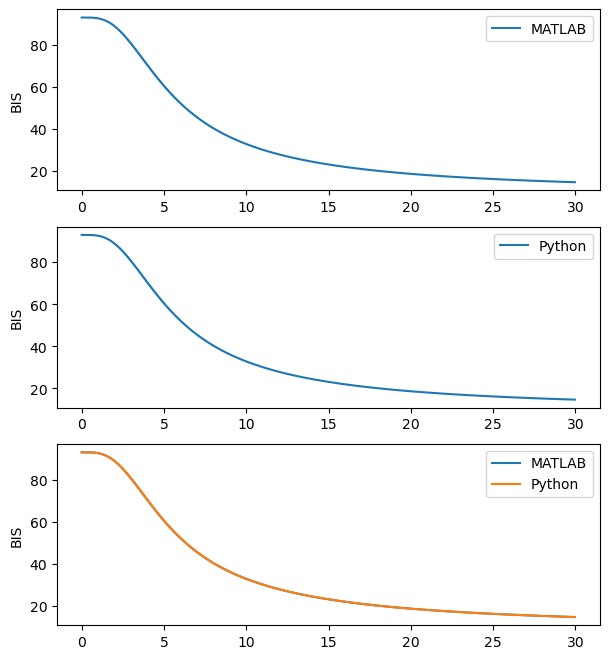

<Figure size 640x480 with 0 Axes>

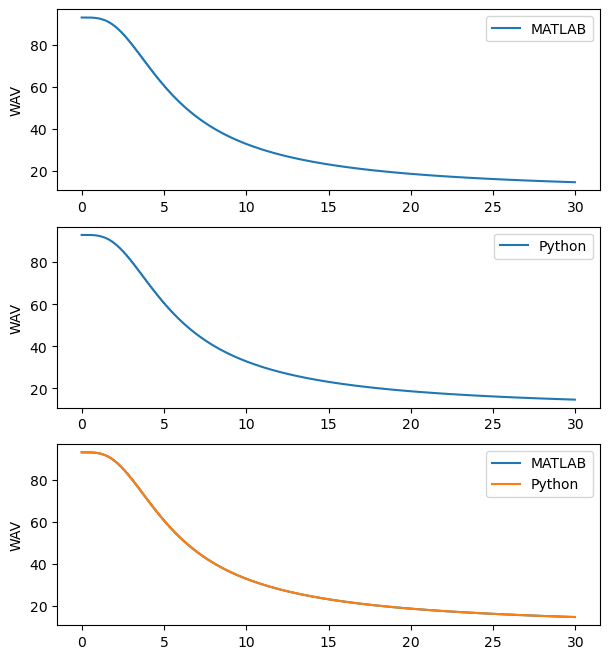

<Figure size 640x480 with 0 Axes>

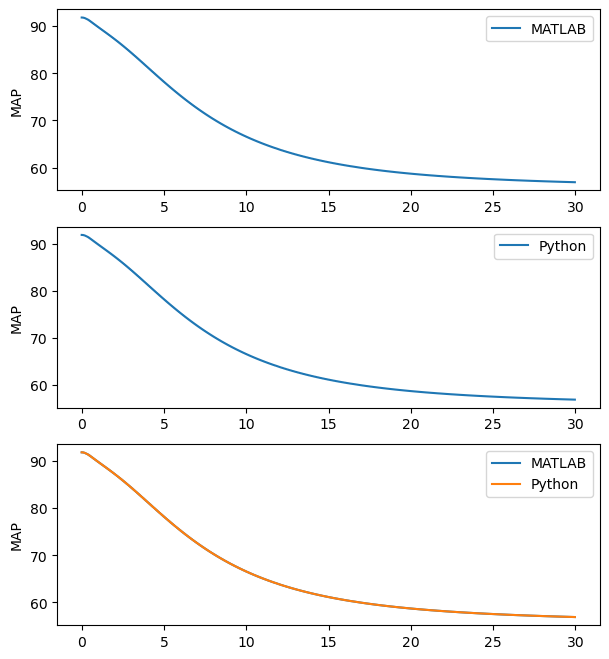

<Figure size 640x480 with 0 Axes>

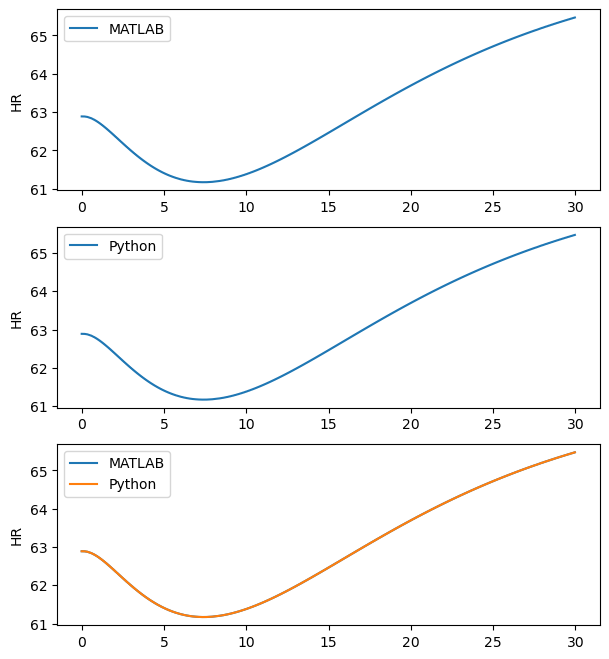

<Figure size 640x480 with 0 Axes>

In [75]:
names = {'bis_all': 'BIS','wav_all':'WAV', 'map_all': 'MAP', 'hr_all': 'HR'}

num_samples = len(matlab_result['bis_all'])
t_sim = np.arange(num_samples-1) / 60

for key in ['bis_all','wav_all', 'map_all', 'hr_all']:
    fig, ax = plt.subplots(3, 1, figsize=(7, 8))  # Taller figure for 3 rows

    ax[0].plot(t_sim,matlab_result[key][:-1],label='MATLAB')
    ax[0].set_ylabel(names[key])
    ax[0].legend()

    ax[1].plot(t_sim,py_results[key][0][:-1], label='Python')
    ax[1].set_ylabel(names[key])
    ax[1].legend()

    ax[2].plot(t_sim,matlab_result[key][:-1], label='MATLAB')
    ax[2].plot(t_sim,py_results[key][0][:-1], label='Python')
    ax[2].set_ylabel(names[key])
    ax[2].legend()

    plt.show()
    plt.clf()

In [76]:
import numpy as np

# Set a threshold value
threshold = 1

def compare_dicts_with_threshold(dict1, dict2, threshold):
    for key in dict1:
        print("Examining key:", key)
        arr1 = np.array(dict1[key])
        arr2 = np.array(dict2[key])
        print("\n")
        
        # Compare all elements except the last one
        diff = np.isclose(arr1[:-1], arr2[0][:-1], atol=threshold)

        if not np.all(diff):
            print("Arrays differ at the following indices:")
            differing_indices = np.where(~diff)[0]
            for idx in differing_indices:
                print(f"Min {idx/60:.0f}: arr1 = {arr1[idx]}, arr2 = {arr2[0][idx]}")
            print("Arrays are not equal within the threshold.\n")

# Compare the two dictionaries
compare_dicts_with_threshold(matlab_result, py_results, threshold)

Examining key: bis_all


Examining key: c_nore_all


Examining key: ce_bis_all


Examining key: ce_del_all


Examining key: ce_prop_all


Examining key: ce_remi_all


Examining key: ce_rocu_all


Examining key: ce_wav_all


Examining key: co_all


Examining key: cp_prop_all


Examining key: cp_remi_all


Examining key: cp_rocu_all


Examining key: hr_all


Examining key: map_all


Examining key: nmb_m0_all


Examining key: nmb_m1_all


Examining key: nmb_m2_all


Examining key: nmb_m3_all


Examining key: sv_all


Examining key: tpr_all


Examining key: u_nore_all


Examining key: u_prop_all


Examining key: u_remi_all


Examining key: u_rocu_all


Examining key: wav_all


